<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/SSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

# LOAD raw data
data = load_breast_cancer()
X = pd.DataFrame(data.data,columns=data.feature_names).values
y = pd.DataFrame(data.target,columns=['target']).replace(0,-1).values

# features scaling
X[:] = MinMaxScaler().fit_transform(X)

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# torch format data
C = 1
A = torch.FloatTensor(X_train)
D = np.diag(y_train.ravel())
D = torch.FloatTensor(D)

# define model
model = nn.Sequential(nn.Linear(A.shape[1],1),
                      nn.Sigmoid())
optimizer = optim.Adam(model.parameters(),lr=0.01)

# help get model param
def get_param(model):
  weight = None
  bias = None
  for i,p in enumerate(model.parameters()):
    if i == 0:
      weight = p
    if i == 1:
      bias = p 
  return weight,bias

# loss function

In [0]:
def loss_function(A,D,model):
  W,b = get_param(model)
  return (C/2)*torch.norm(F.softplus((1-D@(A@W.T+b)),beta=5),p=2)**2 + (1/2)*(torch.norm(W.T)**2 + b**2)

# train

In [0]:
def train(model,A,D,loss_function,optimizer,num_epochs=100):
    train_history = []
    for epoch in range(num_epochs):
        loss = loss_function(A,D,model).sum()    
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_history.append(loss.item())
    
    plt.plot(np.array(train_history),label='train')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    return model.eval()

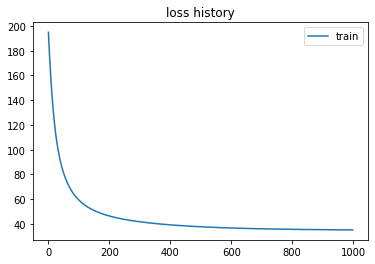

In [4]:
model = train(model,A,D,loss_function,optimizer,num_epochs=1000)

# evaluate

In [0]:
y_pred = model(torch.FloatTensor(X_test)).round()
y_pred = pd.Series(y_pred.detach().numpy().ravel()).replace(0,-1).values

In [0]:
y_real = pd.Series(y_test.reshape(-1)).values

In [7]:
from sklearn.metrics import f1_score

f1_score(y_real,y_pred)

0.9794238683127573